In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

def load_simulation_data(M, T, rho, simJob):
    return np.load("../results-longrun-nohist/argon-M-%d-T-%.2f-rho-%.2f-simjob-%d.npz" % (M,T,rho,simJob))

Ms = [6]
Ts = np.linspace(0.25, 4.0, 16)
rhos = np.concatenate((np.array([0.02, 0.05]), np.linspace(0.1, 2.0, 20)))
simJobs = [0]

In [2]:
testData = load_simulation_data(6, 3.0, 0.2, 0)

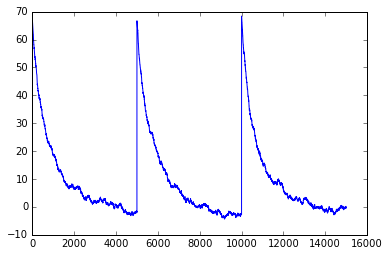

In [3]:
plt.plot(testData["autocorrelation"])

In [4]:
def process_data(dataIn):
    proccedData = dict()
    for key in dataIn:
        if not (key == "autocorrelation" or key == "diffusion_distance"):
            proccedData[key] = dataIn[key]
        elif key == "autocorrelation" or key == "diffusion_distance":
            proccedData[key] = dataIn[key][0:5000]/3 + dataIn[key][5000:10000]/3 + dataIn[key][10000:15000]/3
    return proccedData

In [5]:
pTestData = process_data(testData)

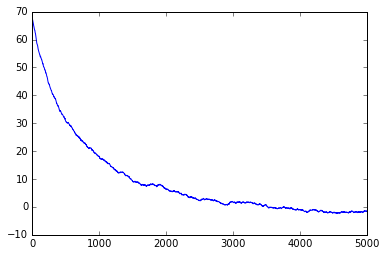

In [6]:
plt.plot(pTestData["autocorrelation"])

In [253]:
def fit_autocorrelation(autoCorr, h, lintail_fit=None):
    # exponential with a certain floor
    residuals = lambda p, x, y: (p[0] * np.exp(-x/p[1]) + (p[2] + x*p[3])) - y
    
    tRange = np.arange(0,len(autoCorr)) * h
    if lintail_fit is None:
        lintail_fit = np.polyfit(tRange[-2000:], autoCorr[-2000:], 1)
        expstart_fit = np.polyfit(tRange[:10], autoCorr[:10], 1)
        residuals = lambda p, x, y: (p[0] * np.exp(-x/np.abs(p[1])) + (p[2] + x*p[3])) - y
        
        expHeightGuess = np.abs(expstart_fit[1] - lintail_fit[1])
        tauGuess = -expHeightGuess/expstart_fit[0]
        
    else:
        residuals = lambda p, x, y: (p[0] * np.exp(-x/np.abs(p[1]))) - y
        ln_fit = np.polyfit(tRange, np.log(np.abs(autoCorr)),1)
        tauGuess = -1/ln_fit[0]
        expHeightGuess = np.exp(ln_fit[1])
    
    
    
    floorGuess = lintail_fit[1]
    linTailGuess = lintail_fit[0]
    #tauGuess = np.abs(- ((autoCorr[1] - floorGuess) / (autoCorr[2]/2 - autoCorr[0]/2)) * h)
    
    guess = np.array([expHeightGuess, tauGuess, floorGuess, linTailGuess])
    
    #print(guess)
    
    fitResults = scipy.optimize.leastsq(residuals, guess, args=(tRange, autoCorr), maxfev=10000)
    
    fitParams = fitResults[0]
    fitParams[1] = np.abs(fitParams[1])
    
    return fitResults[0], guess

[ 62.04975526   3.16629102   0.           0.        ]
[ 35.78033359   4.5627193    0.           0.        ]


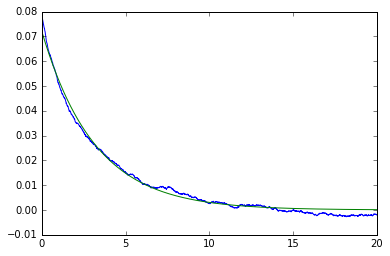

In [295]:
tRange = np.arange(0,len(pTestData["autocorrelation"])) * pTestData["h"]
fitfunc = lambda p, x: (p[0] * np.exp(-x/np.abs(p[1])) + (p[2] + x*p[3]))
plt.plot(tRange, pTestData["autocorrelation"]/pTestData["n"])
a, _ = fit_autocorrelation(pTestData["autocorrelation"], pTestData["h"], [0, 0])
plt.plot(tRange, fitfunc(a, tRange)/pTestData["n"])
print(a)
print(_)

In [278]:
import warnings
warnings.simplefilter("error")

taus = np.zeros((len(Ts), len(rhos), len(simJobs)))
floors = np.zeros((len(Ts), len(rhos), len(simJobs)))
heights = np.zeros((len(Ts), len(rhos), len(simJobs)))
lintails = np.zeros((len(Ts), len(rhos), len(simJobs)))

for i in range(1, len(Ts)):
    for j in range(0, len(rhos)):
        for k in range(0, len(simJobs)):
            with load_simulation_data(6, Ts[i], rhos[j], simJobs[k]) as data:
                # print("T: %.2f, rho: %.2f" % (Ts[i], rhos[j]))
                pData = process_data(data)
                ltf = None
                if rhos[j] < 0.15:
                    # low density, low temperature gas regime: assume no linear tail in the autocorrelation
                    #ltf = np.array([0.0, 0.0])
                    pass
                (heights[i,j,k], taus[i,j,k], floors[i,j,k], lintails[i,j,k]), _ = fit_autocorrelation(pData["autocorrelation"], pData["h"], ltf)

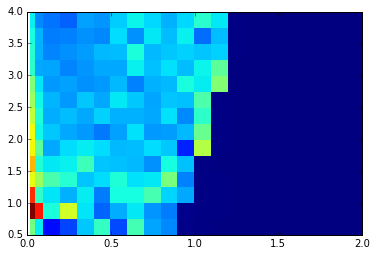

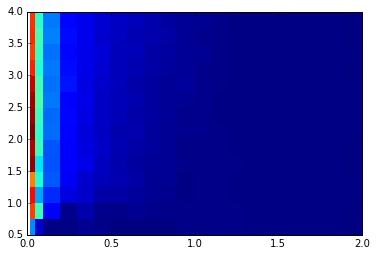

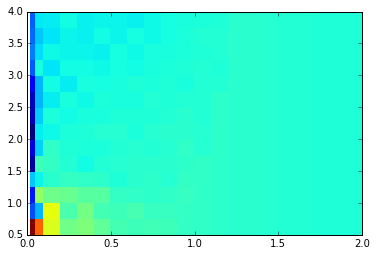

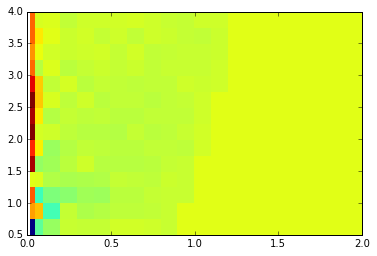

In [283]:
plt.pcolor(rhos, Ts[1:], taus[1:,:,0])
plt.figure()
plt.pcolor(rhos, Ts[1:], heights[1:,:,0])
plt.figure()
plt.pcolor(rhos, Ts[1:], floors[1:,:,0])
plt.figure()
plt.pcolor(rhos, Ts[1:], lintails[1:,:,0])

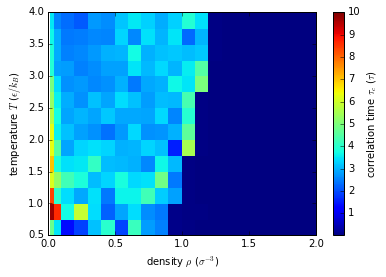

In [290]:
plt.pcolor(rhos, Ts[1:], taus[1:,:,0], vmax=10.0)
cbar = plt.colorbar(label=r"correlation time $\tau_c$ ($\tau$)")
plt.xlabel(r"density $\rho$ ($\sigma ^{-3}$)")
plt.ylabel(r"temperature $T$ ($\epsilon / k_B$)")

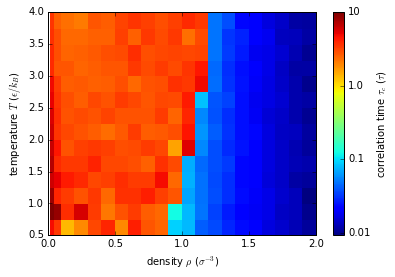

In [293]:
plt.pcolor(rhos, Ts[1:], np.log10(taus[1:,:,0]), vmax=1.0)
cbar = plt.colorbar(label=r"correlation time $\tau_c$ ($\tau$)")
ticklocs = [0.01, 0.1, 1.0, 10]
cbar.set_ticks(np.log10(ticklocs))
cbar.set_ticklabels(ticklocs)
plt.xlabel(r"density $\rho$ ($\sigma ^{-3}$)")
plt.ylabel(r"temperature $T$ ($\epsilon / k_B$)")
plt.savefig("autocorrelation-log-colorplot.png", dpi=300)

[ 148.77212734   41.09945001    0.            0.        ]
[ 147.29843392   42.94666847    0.            0.        ]


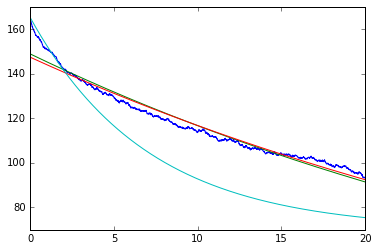

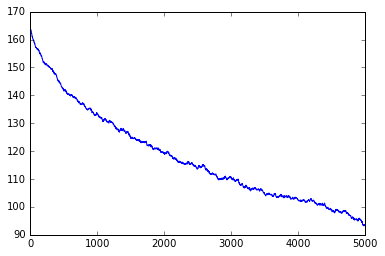

In [275]:
failData = (load_simulation_data(6, 0.5, 0.05, 0))
pFailData = process_data(failData)

autoCorr = pFailData["autocorrelation"]

plt.plot(tRange, autoCorr)

smt = np.convolve(autoCorr, np.ones((10))/10, mode="same")

lintail_fit = np.polyfit(tRange[-2000:], autoCorr[-2000:], 1)
expstart_fit = np.polyfit(tRange[:10], autoCorr[:10], 1)
residuals = lambda p, x, y: (p[0] * np.exp(-x/np.abs(p[1])) + (p[2] + x*p[3])) - y

expHeightGuess = expstart_fit[1] - lintail_fit[1]
tauGuess = -expHeightGuess/expstart_fit[0]

a, _ = fit_autocorrelation(autoCorr, pFailData["h"], [0, 0])
print(a)
print(_)

plt.plot(tRange, fitfunc(a, tRange))
plt.plot(tRange, fitfunc(_, tRange))
plt.plot(tRange, fitfunc([95, 7, 70, 0], tRange))

plt.figure()
plt.plot(autoCorr)

In [232]:
lintail_fit

array([ -7.31108146e-03,   1.63645838e+01])

In [230]:
tauGuess

0.099813218652786015

In [237]:
expHeightGuess

5.0391589285052234

[ 62.04975526   3.16629102   0.           0.        ]
[ 35.78033359   4.5627193    0.           0.        ]


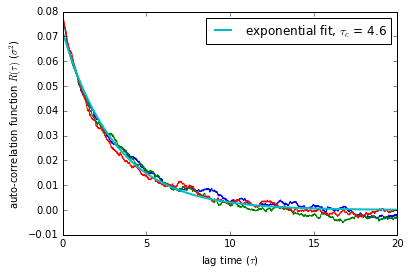

In [317]:
testData = load_simulation_data(6, 3.0, 0.2, 0)
pTestData = process_data(testData)

tRange = np.arange(0,len(pTestData["autocorrelation"])) * pTestData["h"]
fitfunc = lambda p, x: (p[0] * np.exp(-x/np.abs(p[1])) + (p[2] + x*p[3]))

plt.plot(tRange, testData["autocorrelation"][0:5000]/pTestData["n"])
plt.plot(tRange, testData["autocorrelation"][5000:10000]/pTestData["n"])
plt.plot(tRange, testData["autocorrelation"][10000:15000]/pTestData["n"])

a, _ = fit_autocorrelation(pTestData["autocorrelation"], pTestData["h"], [0, 0])

plt.plot(tRange, fitfunc(a, tRange)/pTestData["n"], linewidth=2, label=r"exponential fit, $\tau_c$ = 4.6")
plt.legend()

plt.xlabel(r"lag time ($\tau$)")
plt.ylabel(r"auto-correlation function $R(\tau)$ ($\sigma^2$)")

plt.savefig("longrun/autocorrelation-gas.png", dpi=300)

print(a)
print(_)

[  6.22794864e+00   7.76150886e-02   1.72294607e+01   6.86045054e-03]


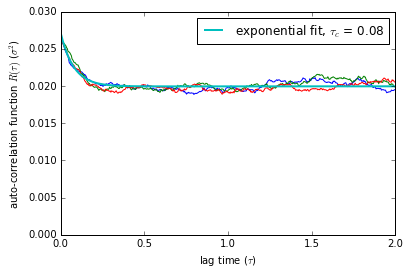

In [333]:
testData = load_simulation_data(6, 0.5, 1.0, 0)
pTestData = process_data(testData)

tRange = np.arange(0,len(pTestData["autocorrelation"])) * pTestData["h"]
fitfunc = lambda p, x: (p[0] * np.exp(-x/np.abs(p[1])) + (p[2] + x*p[3]))

plt.plot(tRange, testData["autocorrelation"][0:5000]/pTestData["n"])
plt.plot(tRange, testData["autocorrelation"][5000:10000]/pTestData["n"])
plt.plot(tRange, testData["autocorrelation"][10000:15000]/pTestData["n"])

a, _ = fit_autocorrelation(pTestData["autocorrelation"], pTestData["h"])

plt.plot(tRange, fitfunc(a, tRange)/pTestData["n"], linewidth=2, label=r"exponential fit, $\tau_c$ = 0.08")
plt.legend()

plt.xlabel(r"lag time ($\tau$)")
plt.ylabel(r"auto-correlation function $R(\tau)$ ($\sigma^2$)")

plt.xlim(0,2)
plt.ylim(0,0.03)

plt.savefig("longrun/autocorrelation-solid.png", dpi=300)

print(a)

In [332]:
7.76150886e-02

0.0776150886